# Calculating band indices with Spyndex packages

* **Products used:** 
[ s2_l2a](https://explorer.digitalearth.africa/s2_l2a) 

## Background

The [Spyndex python package](https://www.nature.com/articles/s41597-023-02096-0) provides access to spectral indices from the Awesome Spectral Indices catalogue which is a standardized ready to use curated list of spectral indices. The Spyndex package has a total of [232 optical and radar indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv) available currently.

One of the benefits of this package is the large number of spectral indices available to the sandbox users for analysis without having to manually add to the notebooks.

## Description
This notebook demonstrates how to:
 
* Load dataset using `load_ard`
* Calculate NDVI and EVI indices using the `spyndex` function 
* Calculate NDVI and EVI indices using the `calculate_indices` function
* Plot the results from both functions

## Getting started
To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Addition to the exsiting pacakges,the spyndex package will be loaded by importing it.

In [1]:
# Load the python packages.
%matplotlib inline

import os

os.environ["USE_PYGEOS"] = "0"

import matplotlib.pyplot as plt

#Import spyndex packages
import spyndex

import datacube

from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import rgb
from deafrica_tools.bandindices import calculate_indices

### Connect to the datacube

In [2]:
# Connect to the datacube
dc = datacube.Datacube(app="spyndex_function")

## Create a query and load satellite data

To demonstrate how to compute a remote sensing index, we first need to load in a time series of satellite data for an area. We will use data from the Sentinel-2 satellite:

It is highly recommended to load data with `load_ard` when calculating indices. This is because `load_ard` performs the necessary data cleaning and scaling for more robust index results. Refer to the [Using_load_ard](../Frequently_used_code/Using_load_ard.ipynb) to learn more

In [3]:
# Define the analysis parameters
lat, lon = 13.94, -16.54
buffer = 0.125

lat_range = (lat + buffer, lat - buffer)
lon_range = (lon - buffer, lon + buffer)

time_range = ("2019-06", "2020-06")


# Create a reusable query object.
query = {
    "x": lon_range, 
    "y": lat_range, 
    "time": time_range, 
    "resolution": (-30, 30)
}

# Identify the most common projection system in the input query
output_crs = mostcommon_crs(dc=dc, product="s2_l2a", query=query)

# Load available data from Sentinel-2 and filter to retain only times
# with at least 99% good data
ds = load_ard(
    dc=dc,
    products=["s2_l2a"],
    min_gooddata=0.99,
    measurements=["red", "green", "blue", "nir"],
    output_crs=output_crs,
    **query
)

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step


/usr/local/lib/python3.8/dist-packages/rasterio/warp.py:346: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  _reproject(


Filtering to 4 out of 78 time steps with at least 99.0% good quality pixels
Applying pixel quality/cloud mask
Loading 4 time steps


### Print the xarray dataset

In [4]:
print(ds)

<xarray.Dataset>
Dimensions:      (time: 4, y: 928, x: 907)
Coordinates:
  * time         (time) datetime64[ns] 2019-10-20T11:47:38 ... 2020-03-18T11:...
  * y            (y) float64 1.556e+06 1.556e+06 ... 1.528e+06 1.528e+06
  * x            (x) float64 3.2e+05 3.201e+05 3.201e+05 ... 3.472e+05 3.472e+05
    spatial_ref  int32 32628
Data variables:
    red          (time, y, x) float32 2.067e+03 1e+03 ... 1.899e+03 1.93e+03
    green        (time, y, x) float32 1.707e+03 1.065e+03 ... 1.337e+03
    blue         (time, y, x) float32 896.0 452.0 520.0 ... 1.009e+03 993.0
    nir          (time, y, x) float32 4.196e+03 4.068e+03 ... 2.842e+03
Attributes:
    crs:           EPSG:32628
    grid_mapping:  spatial_ref


## Plot the images to see how our area looks like
The `rgb` function is used to plot the timesteps in our dataset as true colour RGB images:

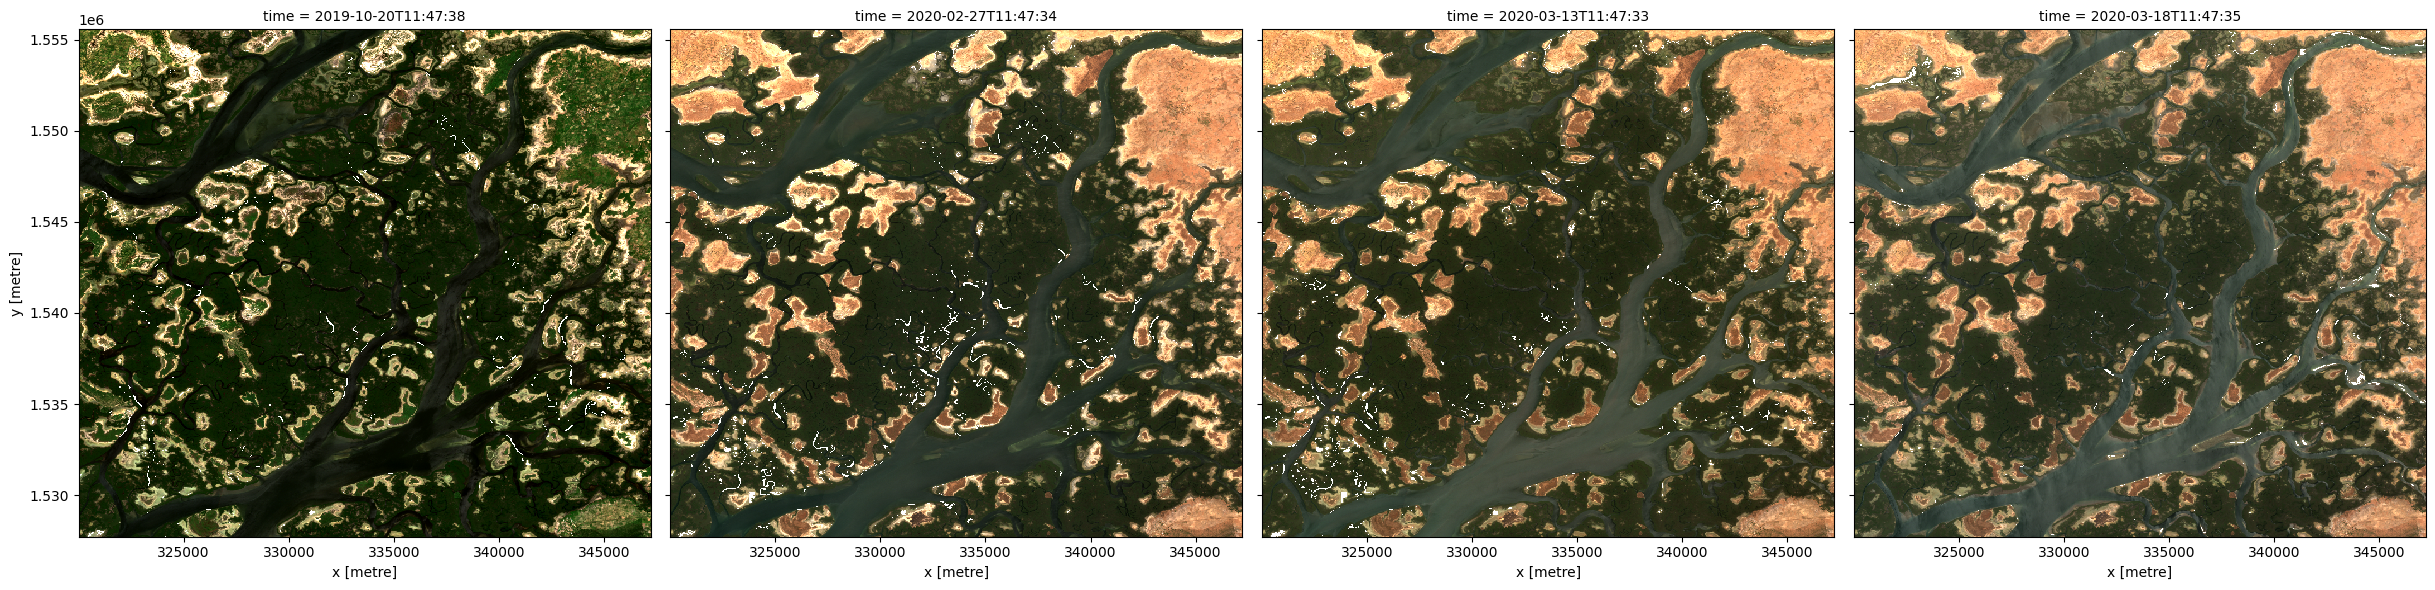

In [5]:
rgb(ds, col="time")

## Calculate NDVI using spyndex
Spyndex Packages comes with [232 indices](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/spectral-indices-table.csv). For this notebook, 2 indices will be used as an example
`NDVI` and `EVI`.

#### Printout the NDVI Index attributes. 
Using `spyndex.indices[indexName]` will give you the detail parameter of the Index being used.
The cell below print out the information concerning `NDVI`

In [6]:
print(spyndex.indices["NDVI"])

NDVI: Normalized Difference Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['N', 'R']
        * Formula: (N-R)/(N+R)
        * Reference: https://ntrs.nasa.gov/citations/19740022614
        


#### Compute the NDVI index using the `spectral computeIndex` method.

In [7]:
ds["NDVI_spyndex"] = spyndex.computeIndex(
    index=["NDVI"], 
    params={
        "N": ds.nir, 
        "R": ds.red
    }
)

#### Compute NDVI using the `calculate indices` function.

In [8]:
ds = calculate_indices(ds, index="NDVI", satellite_mission="s2")

#### Plot the NDVI results.

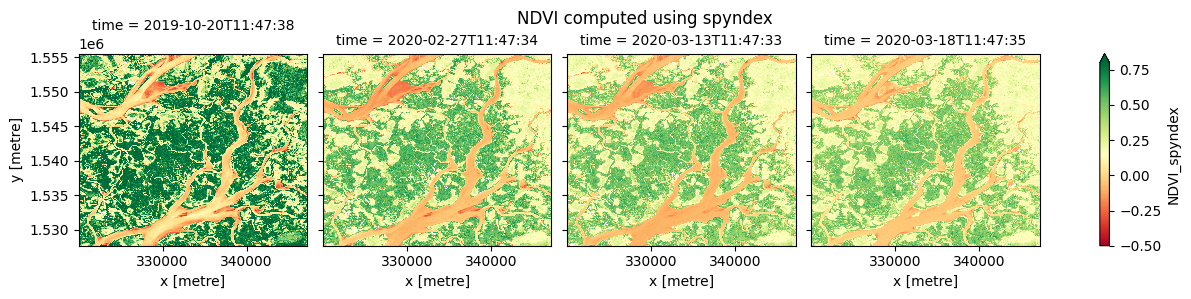

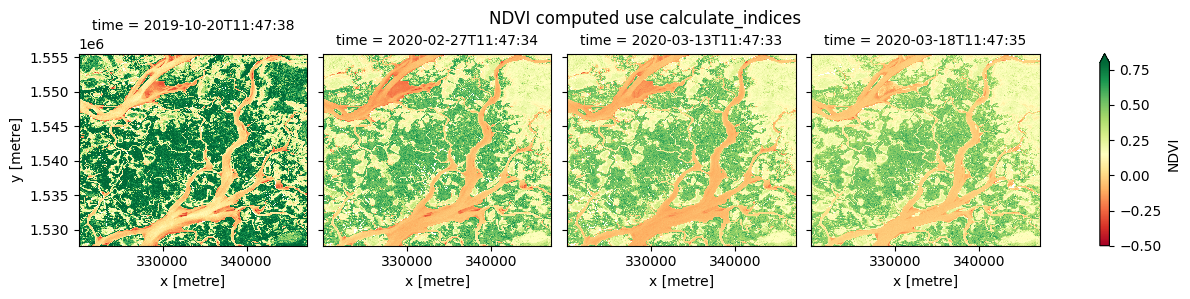

In [9]:
fig_1 = ds.NDVI_spyndex.plot(col="time", vmin=-0.50, vmax=0.8, cmap="RdYlGn")
fig_1.fig.suptitle("NDVI computed using spyndex")

fig_2 = ds.NDVI.plot(col="time", vmin=-0.50, vmax=0.8, cmap="RdYlGn")
fig_2.fig.suptitle("NDVI computed use calculate_indices")

plt.show()

#### Calculate Enhanced Vegetation Index(EVI) using spyndex

In [10]:
print(spyndex.indices["EVI"])

EVI: Enhanced Vegetation Index
        * Application Domain: vegetation
        * Bands/Parameters: ['g', 'N', 'R', 'C1', 'C2', 'B', 'L']
        * Formula: g*(N-R)/(N+C1*R-C2*B+L)
        * Reference: https://doi.org/10.1016/S0034-4257(96)00112-5
        


#### Compute the EVI index using the `spectral computeIndex` method.

From the above indices `EVI` has constants values for its computation. 
Spyndex fucntion provides the constant values which can also be overwritten. The [constants](https://github.com/awesome-spectral-indices/awesome-spectral-indices/blob/main/output/constants.json) can be accessed using `spyndex.constants` as shown below.

In [11]:
ds["EVI_spindex"] = spyndex.computeIndex(
    index=["EVI2"],
    params={
        "C1": spyndex.constants["C1"].value,
        "C2": spyndex.constants["C2"].value,
        "g": spyndex.constants["g"].value,
        "L": spyndex.constants["L"].value,
        "N": ds.nir,
        "R": ds.red,
        "B": ds.blue,
    },
)

#### Compute EVI using the `calculate indices` function.

In [12]:
ds = calculate_indices(ds, index=["EVI"], satellite_mission="s2")

#### Plot the EVI results.

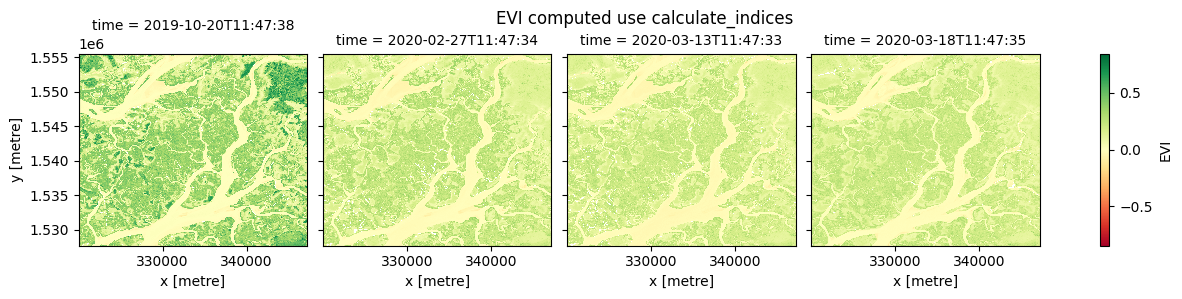

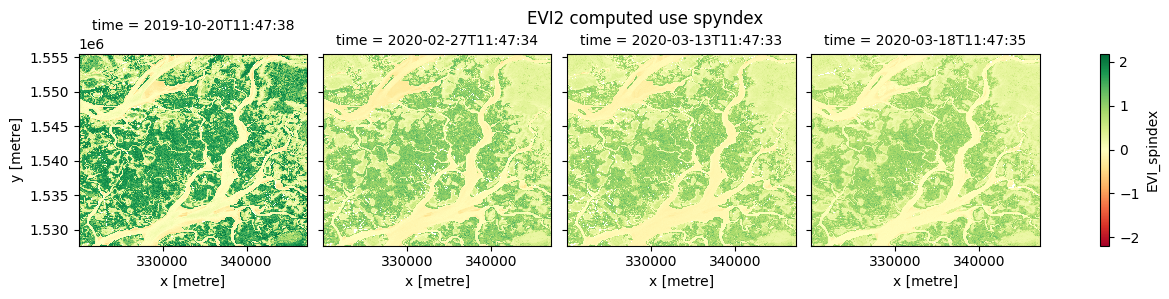

In [13]:
fig_4 = ds.EVI.plot(col="time", cmap="RdYlGn")
fig_4.fig.suptitle("EVI computed use calculate_indices")

fig_5 = ds.EVI_spindex.plot(col="time", cmap="RdYlGn")
fig_5.fig.suptitle("EVI2 computed use spyndex");

plt.show()

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [14]:
print(datacube.__version__)

1.8.8


**Last Tested:**

In [15]:
from datetime import date
print(date.today())

2023-05-23
